In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [50]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384328


In [3]:
# list_justificativa = random.sample(list_justificativa, 120000)

# print(list_justificativa[:10])

In [51]:
n_comp = 50

In [52]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [53]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [54]:
print(X_count.shape)

(384328, 154)


In [55]:
# count the number of entries > 0
count = (X_count[X_count > 0]).shape[1]
min_k = X_count.shape[0] * X_count.shape[1] // count
max_k = min_k * 3
min_k = min_k // 2

# true_k = 300
# cite https://dl.acm.org/doi/pdf/10.1145/99935.99938
print(min_k, max_k)

18 111


In [56]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [57]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.64 for 50 components


In [58]:
res_df = pd.DataFrame(columns=['k', 'inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [59]:
for k in range(min_k, max_k+1):
    print(f"Running kmeans for k={k}")
    # running kmeans
    model = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

    labels=model.labels_

    inertia = model.inertia_
    silhouette = metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)
    calinski_harabasz = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin = metrics.davies_bouldin_score(X, labels)

    res_df.loc[len(res_df)] = {'k': k, 'inertia': inertia, 'silhouette': silhouette,
                            'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}

Running kmeans for k=18
Running kmeans for k=19
Running kmeans for k=20
Running kmeans for k=21
Running kmeans for k=22
Running kmeans for k=23
Running kmeans for k=24
Running kmeans for k=25
Running kmeans for k=26
Running kmeans for k=27
Running kmeans for k=28
Running kmeans for k=29
Running kmeans for k=30
Running kmeans for k=31
Running kmeans for k=32
Running kmeans for k=33
Running kmeans for k=34
Running kmeans for k=35
Running kmeans for k=36
Running kmeans for k=37
Running kmeans for k=38
Running kmeans for k=39
Running kmeans for k=40
Running kmeans for k=41
Running kmeans for k=42
Running kmeans for k=43
Running kmeans for k=44
Running kmeans for k=45
Running kmeans for k=46
Running kmeans for k=47
Running kmeans for k=48
Running kmeans for k=49
Running kmeans for k=50
Running kmeans for k=51
Running kmeans for k=52
Running kmeans for k=53
Running kmeans for k=54
Running kmeans for k=55
Running kmeans for k=56
Running kmeans for k=57
Running kmeans for k=58
Running kmeans f

## Elbow Method

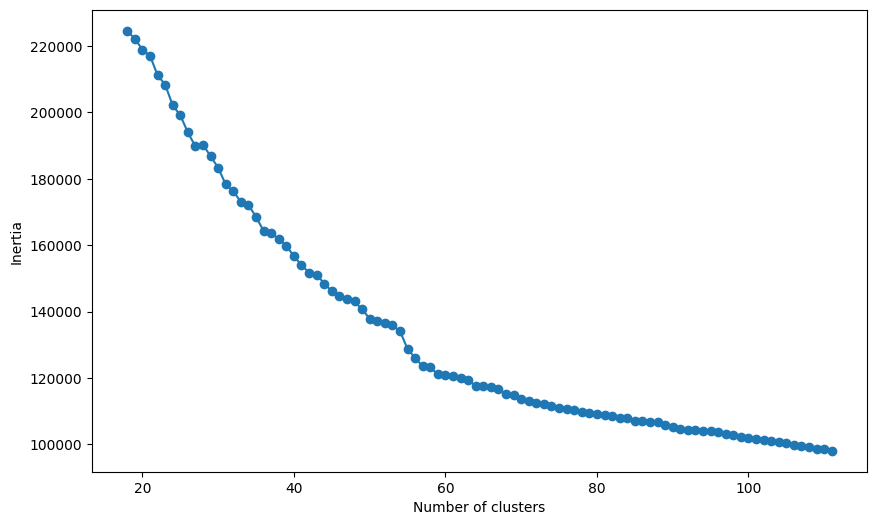

In [60]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['inertia'], marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()


## Silhouette Coefficient

In [61]:
# max silhouette
print(res_df.loc[res_df['silhouette'].idxmax()])

k                      111.000000
inertia              98123.257449
silhouette               0.338195
calinski_harabasz     8744.967800
davies_bouldin           1.693101
Name: 93, dtype: float64


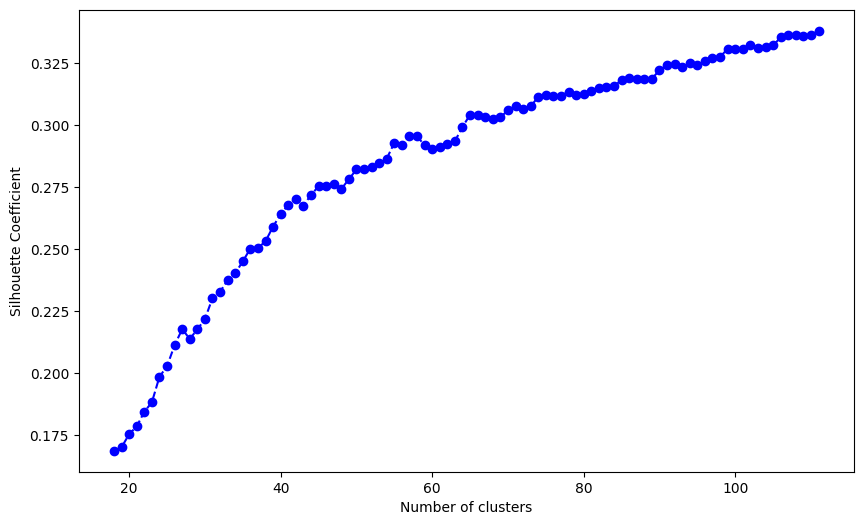

In [62]:
# 2d plot silhouette for each k

plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['silhouette'], marker='o', linestyle='--', color='b')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

plt.show()



## Calinski-Harabasz Index

In [63]:
# max Calinski-Harabasz
print(res_df.loc[res_df['calinski_harabasz'].idxmax()])

k                        57.000000
inertia              123506.582968
silhouette                0.295536
calinski_harabasz     12238.865633
davies_bouldin            1.352600
Name: 39, dtype: float64


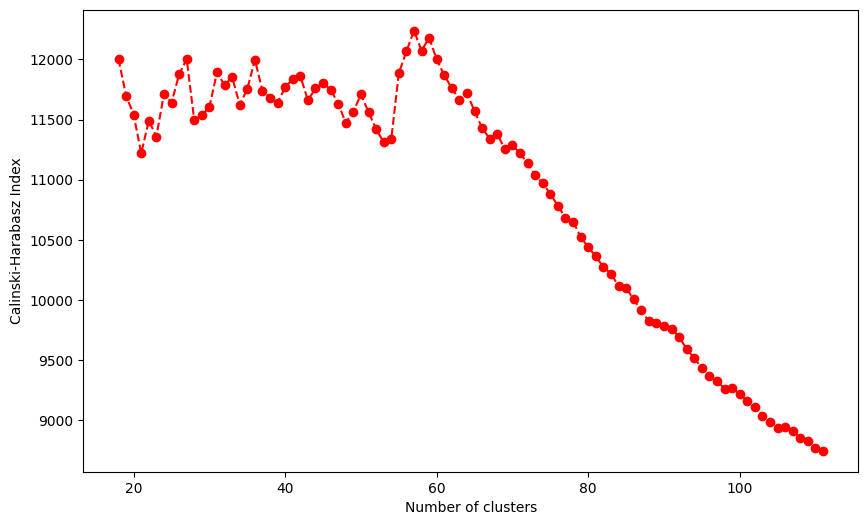

In [64]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['calinski_harabasz'], marker='o', linestyle='--', color='r')

plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.show()

## Davies-Bouldin Index

In [65]:
# max davies_bouldin
print(res_df.loc[res_df['davies_bouldin'].idxmin()])

k                        57.000000
inertia              123506.582968
silhouette                0.295536
calinski_harabasz     12238.865633
davies_bouldin            1.352600
Name: 39, dtype: float64


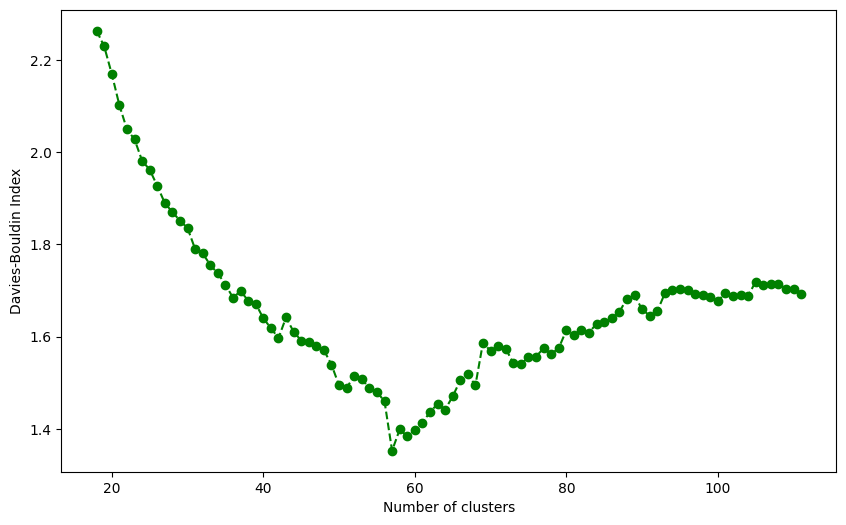

In [66]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['davies_bouldin'], marker='o', linestyle='--', color='g')

plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.show()

In [146]:
choosen_k = 57

In [147]:
model = KMeans(n_clusters=choosen_k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

labels=model.labels_
clusters=pd.DataFrame(list(zip(sample,labels)),columns=['phrase','cluster'])
clusters['cluster'].value_counts()

cluster
8     18201
25    11929
30    10089
38     9524
5      9518
3      9251
16     9093
42     8821
49     8519
7      8304
12     8297
32     8259
22     8257
19     8092
37     8053
36     8043
18     8012
45     7986
21     7956
9      7751
14     7384
52     7247
51     7137
40     7082
17     6935
47     6863
28     6862
4      6813
23     6773
44     6676
11     6648
50     6644
15     6508
48     6234
56     5925
34     5922
33     5875
0      5849
41     5457
13     5427
1      5338
46     5267
29     5194
2      4718
43     4623
24     4605
20     4408
54     4271
10     4239
26     4145
55     4047
27     3973
53     3713
39     3431
35     3018
31     2780
6      2342
Name: count, dtype: int64

In [148]:
# quantize the clusters
clusters_count = clusters.groupby('cluster').count()
clusters_count = clusters_count.sort_values(by=['phrase'], ascending=False)

clusters_count.head(10)

,phrase
cluster,
8,18201
25,11929
30,10089
38,9524
5,9518
3,9251
16,9093
42,8821
49,8519


<Axes: xlabel='phrase'>

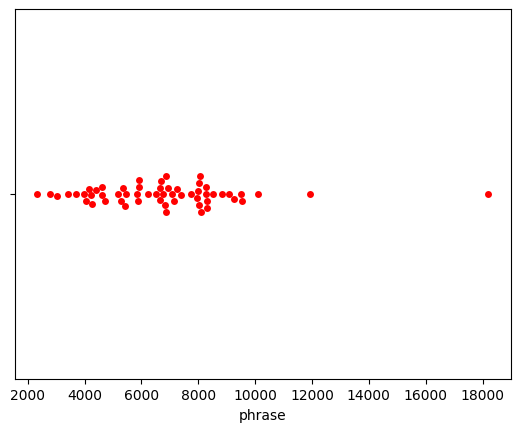

In [149]:
# 1-D swarmplot
sns.swarmplot(x=clusters_count['phrase'], color="red")

In [150]:

#print(clusters.sort_values(by=['cluster']))
# find the centroids
original_space_centroids = lsa[0].inverse_transform(model.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# for i in range(10):
#     print("#Cluster TOP %d" % (i+1)),
#     print("Cluster %d:" % clusters_count.index[i])

#     for ind in order_centroids[clusters_count.index[i], :10]:
#         print(" %s" % terms[ind])

for i in range(choosen_k):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % clusters_count[clusters_count.index == i].values[0][0])
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("------------------------------------------")

    for phr in clusters[clusters['cluster']==i]['phrase'].unique()[:20]:
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 5849
 autorizada
 viagem
 data
 conforme
 anexo
 missao
 tecnica
 dia
 superior
 carater
------------------------------------------
  remarcacao autorizada conforme documentacao anexada
  remarcacao autorizada
  viagem autorizada conforme aev anexo
  viagem autorizada habil devido exercicio permitido empenho data motivo encontra prazo
  autorizada oficio
  autorizada pro reitoria ensino
  considerando data envio oficio convidando reuniao considerando tratar assunto estrategico interesse cvpaf m crpaf go considerando prejuizo administracao descumprimento prazo emissao passagem viagem autorizada crpaf go
  viagem autorizada superintendente adjunto conforme consta anexo
  conforme prorrogacao autorizada oficio
  viagem autorizada realizada aguardando pagamento diarias
  viagem autorizada chefe ue r
  autorizada data
  viagem tornou urgente devido empenho mesma havia sido autorizada vice presidente voos encontram reservados manter valores emisscao
  viagem autoriza

In [151]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [152]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=100000, random_state=42)

0.2954140915799626

## Calinski-Harabasz Index

In [153]:
metrics.calinski_harabasz_score(X, labels)

12238.865632681716

## Davies-Bouldin Index

In [154]:
metrics.davies_bouldin_score(X, labels)

1.352600334424291